In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

## Q1.2: Lucas-Kanade Tracking

Make sure to comment your code and use proper names for your variables. 

In [29]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline as RBS

# The function below could be useful as well :) 
from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
	
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    dp_thresh = 1
    i = 0
    
    It_spline = RBS(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1_spline = RBS(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    x = np.linspace(rect[0], rect[2], 87)
    y = np.linspace(rect[1], rect[3], 36)
    x_mesh, y_mesh = np.meshgrid(x, y)
    It_inter = It_spline.ev(y_mesh, x_mesh).flatten()

    
    while (i <= num_iters) and (dp_thresh >= threshold):
        #Derivatives
        xp = np.linspace(rect[0] + p[0], rect[2] + p[0], 87)
        yp = np.linspace(rect[1] + p[1], rect[3] + p[1], 36)
        xp_mesh, yp_mesh = np.meshgrid(xp, yp)
        It1_inter = It1_spline.ev(yp_mesh, xp_mesh).flatten()
    
        It1_grad_x = It1_spline.ev(yp_mesh, xp_mesh, dx = 1, dy = 0).flatten()
        It1_grad_y = It1_spline.ev(yp_mesh, xp_mesh, dx = 0, dy = 1).flatten()
        
        A = np.zeros((It1_grad_x.shape[0], 2))
        
        A[:, 0] = It1_grad_y
        A[:, 1] = It1_grad_x

        # print(A.shape)
        
        b = It_inter - It1_inter
        
        
        delta_p,_,_,_ = lstsq(A, b, rcond = None)

        #Similar results if delta_p is calculated as shown below
        #delta_p = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(A), A)), np.transpose(A)), b)
        #delta_p = np.linalg.pinv(A) @ b
        
        p += delta_p
        
        dp_thresh = np.linalg.norm(delta_p)
#         dp_thresh = np.sum(delta_p**2)
#         print(dp_thresh)
        
#         if (dp_thresh <= threshold):
#             print("Iteration number:", i)
#             print("Threshold hit:", dp_thresh)
#         if (i == num_iters-1):
#             print("Threshold hit:", dp_thresh)
            
        
        i += 1
    
#     print("Final p:", p)
    # ----------------------------------------------------------------------------------------------
    return p

### Debug Q1.2 

A few tips to debug your implementation:
- You can use the short snippet of code below to test if you get reasonable results. The snippet simply 
checks visualizes the resulting p from running LK on a single frame. You should be able to see a slight shift in the template. 

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

(240, 320, 415)
86 35
Rectangle(xy=(190.554, 191.089), width=86, height=35, angle=0)


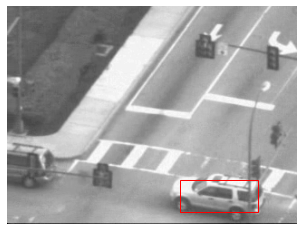

In [30]:
num_iters = 10
threshold = 0.01
seq = np.load('C:\\Users\\prana\\Desktop\\Carnegie Mellon\\Computer Vision\\hw2-s23\\hw2\\data\\carseq.npy')
print(seq.shape)
rect = [59, 116, 145, 151]
It = seq[:,:,0]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
print(w, h)

# Initial frame
# plt.figure()
# currentAxis = plt.gca()
# rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
# currentAxis.add_patch(rect_draw_It1)

# TODO: run LK and update template and plot 
#----------------------------------------------------------------------------------------------
# plt.figure()
for i in range(100):
    It1 = seq[:, :, i]
    p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
    rect = [rect[0] + p[0], rect[1] + p[1], rect[2] + p[0], rect[3] + p[1]]
    It = It1
    
    
plt.figure()
currentAxis = plt.gca()

plt.imshow(It1, cmap='gray')
plt.axis('off')

rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
print(rect_draw_It1)

currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')
plt.show()
# ----------------------------------------------------------------------------------------------

## Q1.3: Track Sequence

In [31]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    
    tmp_rect1 = rect.copy()
    rects = [tmp_rect1]
    It = seq[:, :, 0]
        
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest. Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:, :, i]
        
        p = LucasKanade(It, It1, rect, threshold, num_iters)
        
        tmp_rect2 = rect.copy()
        tmp_rect2[0] += p[0]
        tmp_rect2[1] += p[1]
        tmp_rect2[2] += p[0]
        tmp_rect2[3] += p[1]
        
        
        rects.append(tmp_rect2[:])
        rect = tmp_rect2
        
        It = It1
    
    # ----------------------------------------------------------------------------------------------
        
    rects = np.array(rects)
    
    # Just a sanity check
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not {N}x{4}"
    return rects

### Q1.3: Track Car Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [32]:
seq = np.load("../data/carseq.npy")
# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 10
threshold = 1e-3

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/carseqrects.npy', rects)

100%|██████████| 414/414 [00:19<00:00, 21.21it/s]


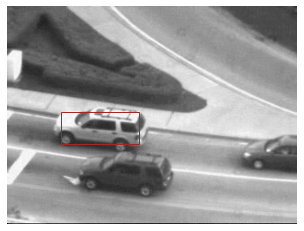

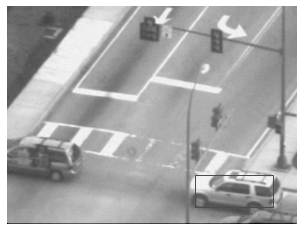

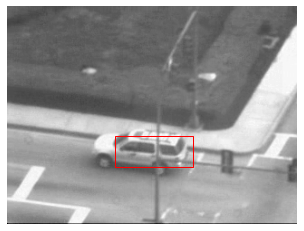

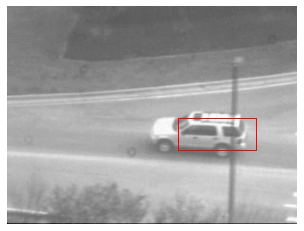

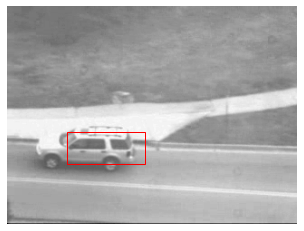

In [33]:
# TODO: visualize. You can make this into a function to re-use it for other visualization questions. 
# List of frames to save
frames_to_save = [0, 79, 159, 279, 409]
# frames_to_save = [0, 1, 2, 3, 4]
for idx in frames_to_save:
    frame = seq[:, :, idx]
    rect = rects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")
    
    # NOTE: here's an example on how to visualize a frame with its template. 
    # frame = 
    # rect = 
    # w = 
    # h = 
    # plt.figure()
    # axis = plt.gca()
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # axis.add_patch(rect_draw)
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")


### Q1.3: Test Girl Sequence

Same drill as with the car sequence. 

In [34]:
seq_girl = np.load("../data/girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 10 
threshold = 1e-3

rects = TrackSequence(seq_girl, rect, num_iters, threshold)
np.save(f'../out/girlseqrects.npy', rects)

100%|██████████| 89/89 [00:15<00:00,  5.88it/s]


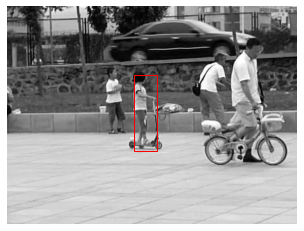

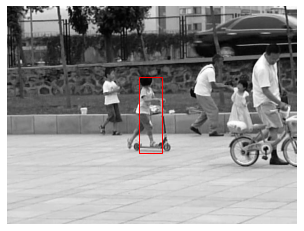

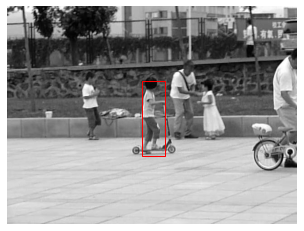

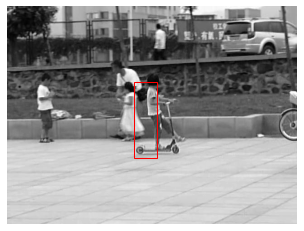

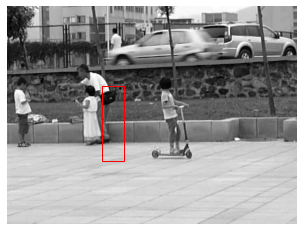

In [35]:
# TODO: visualize. You can copy-and-paste your visualization code from before (or re-use the function)
frames_to_save = [0, 14, 34, 64, 84]

for idx in frames_to_save:
    frame = seq_girl[:, :, idx]
    rect = rects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_girlseq_{idx+1}.png")
    
    # NOTE: here's an example on how to visualize a frame with its template. 
    # frame = 
    # rect = 
    # w = 
    # h = 
    # plt.figure()
    # axis = plt.gca()
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # axis.add_patch(rect_draw)
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")

## Q1.4: Tracking with Template Correction 

In [36]:
def TrackSequenceWithTemplateCorrection(seq, rect_0, num_iters, lk_threshold, drift_threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    rect = np.copy(rect_0)
    rects_wtcr =[rect_0]
    
    It = seq[:,:,0]
    It0 = seq[:,:,0]
    
    print(It.shape)
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest and do template correction.
    #  Add your code here:
    
    p_star_prev = np.zeros(2)
    
    for i in tqdm(range(1, seq.shape[2])):
#         print("iteration number:", i)
        It1 = seq[:, :, i]
        
#         print("It1 shape:", It1.shape)
        It1_spline = RBS(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
        
        p = LucasKanade(It, It1, rect, lk_threshold, num_iters, p0 = np.zeros(2))
        p_star = LucasKanade(It0, It1, rect_0, lk_threshold, num_iters, p_star_prev)

        # print(It0)
        # print("p:", p)
        # # print("pstar", p_star)
        
        # print(rect)
        # print(rect_0)

        tmp_rect2 = rect.copy()
        p_tot = np.zeros(2)
        p_tot[0] = p[0] + rect[0] - rect_0[0]
        p_tot[1] = p[1] + rect[1] - rect_0[1]

        
        if (np.linalg.norm(p_star - p_tot) <= drift_threshold):            
#             print("Update shape:", It.shape)
            # print("Below Threshold")
            tmp_rect2[0] = rect_0[0] + p_star[0]
            tmp_rect2[1] = rect_0[1] + p_star[1]
            tmp_rect2[2] = rect_0[2] + p_star[0]
            tmp_rect2[3] = rect_0[3] + p_star[1]

            It = It1
            
#             xp = np.linspace(tmp_rect2[0], tmp_rect2[2], 87)
#             yp = np.linspace(tmp_rect2[1], tmp_rect2[3], 36)
#             xp_mesh, yp_mesh = np.meshgrid(xp, yp)
# #             print("Spline shape:", It1_spline.ev(yp_mesh, xp_mesh).shape)
#             It = It1_spline.ev(yp_mesh, xp_mesh)
# #             print(It.shape)
            
        else:
            print("Threshold exceded")
        #     tmp_rect2[0] += p[0]
        #     tmp_rect2[1] += p[1]
        #     tmp_rect2[2] += p[0]
        #     tmp_rect2[3] += p[1]
            # It = It1
            
        
        rects_wtcr.append(tmp_rect2[:])
        rect = tmp_rect2
        p_star_prev = p_star

    # ----------------------------------------------------------------------------------------------
    rects_wtcr = np.array(rects_wtcr)
    # Just a sanity check
    assert rects_wtcr.shape == (N, 4), f"Your output sequence {rects_wtcr.shape} is not {N}x{4}"
    return rects_wtcr

### Q1.4: Track Car Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [37]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 10
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/carseqrects-wtcr.npy", rects)

(240, 320)


100%|██████████| 414/414 [00:42<00:00,  9.76it/s]


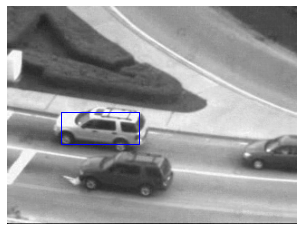

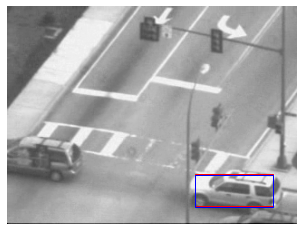

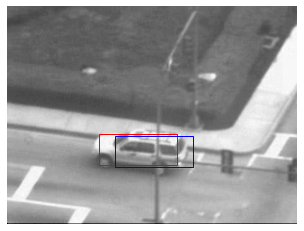

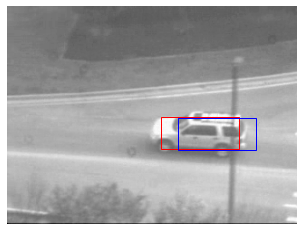

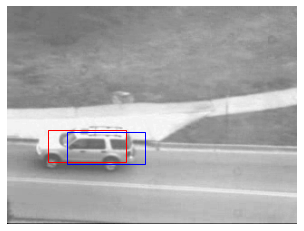

In [38]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [0, 79, 159, 279, 409]
# frames_to_save = [0, 10, 20, 30, 40]

rects_wtcr = np.load("../out/carseqrects-wtcr.npy")
rects = np.load("../out/carseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx]
    rect = rects[idx]
    frame = seq[:, :, idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wtcr_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wtcr_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_carseq_{idx+1}.png")

### Q1.4: Track Girl Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [39]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 10
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/girlseqrects-wtcr.npy", rects)

(480, 640)


100%|██████████| 89/89 [00:34<00:00,  2.57it/s]


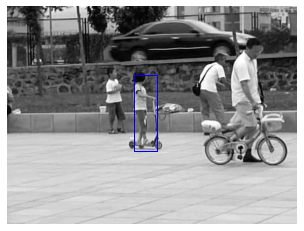

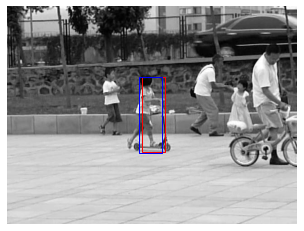

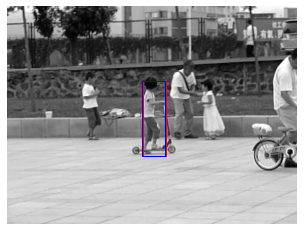

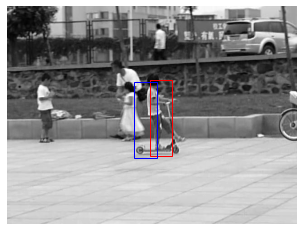

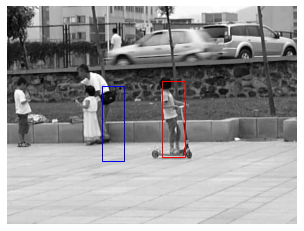

In [40]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [0, 14, 34, 64, 84]

rects_wtcr = np.load("../out/girlseqrects-wtcr.npy")
rects = np.load("../out/girlseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx]
    rect = rects[idx]
    frame = seq[:, :, idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wtcr_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wtcr_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_girlseq_{idx+1}.png")
    # rect_wtcr = 
    # rect = 
    # frame = 

    # plt.figure()
    # currentAxis = plt.gca()
    # rect_wcrt_draw = patches.Rectangle(
    #     (rect_wcrt[0], rect_wcrt[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # currentAxis.add_patch(rect_wcrt_draw)
    
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # currentAxis.add_patch(rect_draw)
    
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.4_girlseq_{idx+1}.png")